# Accelerometer Dataprep
> goal is to determine if activity is predicting adherence.

## Review 
- review what the outcome variables should be
- look at papers to determine if there is precedent of correlation
- aggregate data needed from accelerometers
- save in an accessible spot

# Review of the acceleration time series

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172800 entries, 0 to 172799
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   timestamp  172800 non-null  datetime64[ns, UTC]
 1   anglez     172800 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(1)
memory usage: 2.0 MB
None


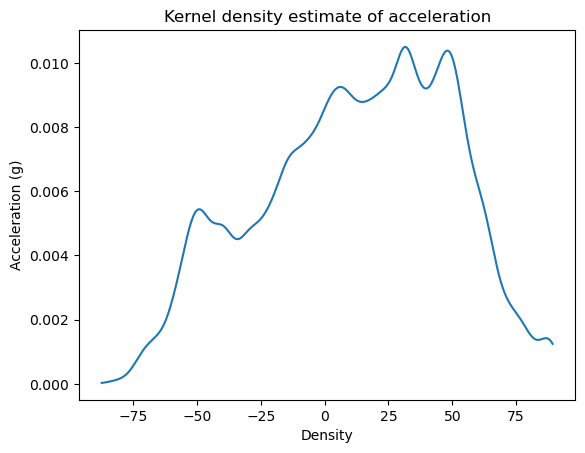

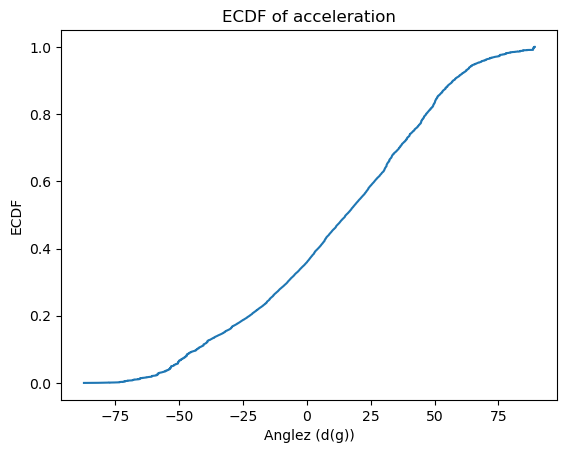

In [2]:
# first view the time series of acceleration 
import pandas as pd
import matplotlib.pyplot as plt

usecols = ["timestamp", "anglez"]

df = pd.read_csv(
    "/mnt/lss/Projects/BOOST/InterventionStudy/3-experiment/data/act-int-test/derivatives/GGIR-3.2.6-test-ncp-sleep2/sub-8005/accel/ses-1/output_ses-1/meta/csv/sub-8005_ses-1_accel.csv.RData.csv",
    usecols=usecols,
    dtype={"anglez": "float32"},
    parse_dates=["timestamp"],          
    engine="pyarrow"                    
)

# quick sanity check
print(df.info(memory_usage="deep"))


import numpy as np
from scipy.stats import gaussian_kde

values = df["anglez"].dropna().to_numpy()
kde = gaussian_kde(values, 'silverman')


x = np.linspace(values.min(), values.max(), 500)
y = kde(x)

plt.plot(x, y)  
plt.xlabel("Density")
plt.ylabel("Acceleration (g)")
plt.title("Kernel density estimate of acceleration")
plt.show()



import numpy as np
x = np.sort(df["anglez"].to_numpy())
y = np.arange(1, x.size + 1) / x.size
plt.plot(x, y, drawstyle="steps-post")
plt.xlabel("Anglez (d(g))"); plt.ylabel("ECDF")
plt.title("ECDF of acceleration")
plt.show()


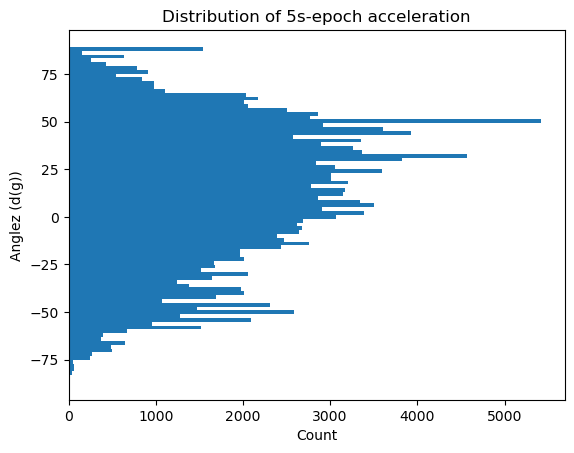

In [22]:
plt.hist(df["anglez"].dropna(), bins="auto", edgecolor="none", orientation="horizontal")
plt.ylabel("Anglez (d(g))")
plt.xlabel("Count")
plt.title("Distribution of 5s-epoch acceleration")
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 91922 entries, 24 to 172785
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timestamp  91922 non-null  datetime64[ns, UTC]
 1   ENMO       91922 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(1)
memory usage: 1.8 MB
None


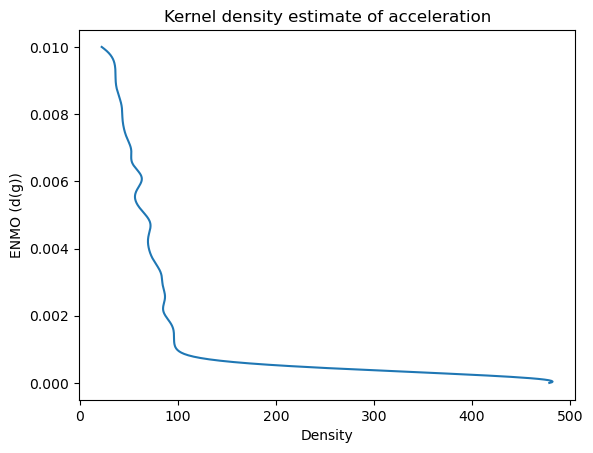

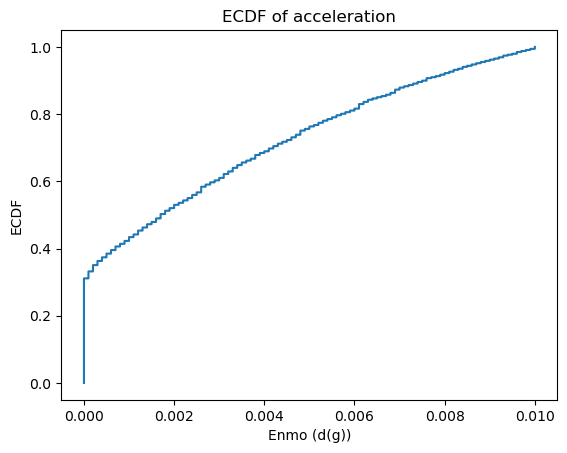

In [5]:
usecols = ["timestamp", "ENMO"]

df = pd.read_csv(
    "/mnt/lss/Projects/BOOST/InterventionStudy/3-experiment/data/act-int-test/derivatives/GGIR-3.2.6-test-ncp-sleep2/sub-8005/accel/ses-1/output_ses-1/meta/csv/sub-8005_ses-1_accel.csv.RData.csv",
    usecols=usecols,
    dtype={"ENMO": "float32"},
    parse_dates=["timestamp"],          
    engine="pyarrow")

df = df[df["ENMO"] <= 0.01]

# quick sanity check
print(df.info(memory_usage="deep"))


import numpy as np
from scipy.stats import gaussian_kde

values = df["ENMO"].dropna().to_numpy()
kde = gaussian_kde(values)

x = np.linspace(values.min(), values.max(), 500)
y = kde(x)

plt.plot(y, x) 
plt.xlabel("Density")
plt.ylabel("ENMO (d(g))")
plt.title("Kernel density estimate of acceleration")
plt.show()


import numpy as np
x = np.sort(df["ENMO"].to_numpy())
y = np.arange(1, x.size + 1) / x.size
plt.plot(x, y, drawstyle="steps-post")
plt.xlabel("Enmo (d(g))"); plt.ylabel("ECDF")
plt.title("ECDF of acceleration")
plt.show()


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, lfilter_zi, lfilter

# Define filter coefficients from the paper (7th-order IIR bandpass)
# Note: These are for the specific transfer function; apply per axis
b = np.array([-0.00934, -0.0255, -0.00424, 0.0442, 0.0365, -0.0119, -0.0229, -0.00679])  # Numerator
a = np.array([1, -3.63, 5.04, -3.10, 0.506, 0.324, -0.157, 0.0195])  # Denominator

# Rescaling factor
rescale_factor = 17.127404  # Approx 3.0/4096 / (2.6/256) * 237.5

def neishabouri_counts(raw_signal, fs, epoch_sec=60):
    """
    Compute Neishabouri counts for a single-axis raw signal.
    
    Parameters:
    - raw_signal: np.array, raw acceleration (1D, in g)
    - fs: int, sampling frequency in Hz
    - epoch_sec: int, epoch length in seconds
    
    Returns:
    - counts: np.array, counts per epoch
    """
    # Step 1: Resample to 30 Hz (simplified; use scipy.signal.resample for actual)
    # For simplicity, assume fs is 30 Hz or multiple; implement full up/downsample if needed
    target_fs = 30
    if fs != target_fs:
        # Placeholder: Resample (in practice, use scipy.signal.resample_poly for integer factors)
        raise ValueError("Implement resampling for non-30 Hz data")
    
    # Step 2: Bandpass filter
    # Find initial conditions for steady state (zi = lfilter_zi(b, a) * raw_signal[0])
    zi = lfilter_zi(b, a) * raw_signal[0]
    filtered, _ = lfilter(b, a, raw_signal, zi=zi)
    
    # Step 3: Rescale
    rescaled = filtered * rescale_factor
    
    # Step 4: Rectify (absolute value)
    rectified = np.abs(rescaled)
    
    # Step 5: Clip/threshold
    clipped = np.floor(rectified).astype(int)
    clipped[clipped < 4] = 0
    clipped[clipped > 128] = 128
    
    # Step 6: Aggregate to 10 Hz by summing every 3 samples (30 Hz -> 10 Hz)
    n_samples_10hz = len(clipped) // 3
    aggregated_10hz = np.sum(clipped[:n_samples_10hz * 3].reshape(-1, 3), axis=1)
    
    # Step 7: Sum over epochs (e.g., for 60-sec epoch: 600 samples at 10 Hz)
    samples_per_epoch = epoch_sec * 10  # 10 Hz
    n_epochs = len(aggregated_10hz) // samples_per_epoch
    counts = np.sum(
        aggregated_10hz[:n_epochs * samples_per_epoch].reshape(-1, samples_per_epoch),
        axis=1
    )
    
    return counts

# Example usage (for one axis; repeat for X, Y, Z)
raw_x = np.random.randn(1800)  # Example: 60 sec at 30 Hz
fs = 30
epoch = 60
counts_x = neishabouri_counts(raw_x, fs, epoch)
print(counts_x)  # Array of counts per epoch